<h1>CS4618: Artificial Intelligence I</h1>
<h1>Linear Models</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import add_dummy_feature

from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DatFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values
    
# Class, for use in pipelines, to binarize nominal-valued features (while avoiding the dummy variabe trap)
# By Derek Bridge, 2017
class FeatureBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, features_values):
        self.features_values = features_values
        self.num_features = len(features_values)
        self.labelencodings = [LabelEncoder().fit(feature_values) for feature_values in features_values]
        self.onehotencoder = OneHotEncoder(sparse=False,
            n_values=[len(feature_values) for feature_values in features_values])
        self.last_indexes = np.cumsum([len(feature_values) - 1 for feature_values in self.features_values])
    def fit(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        return self.onehotencoder.fit(X)
    def transform(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        onehotencoded = self.onehotencoder.transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def fit_transform(self, X, y=None):
        onehotencoded = self.fit(X).transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def get_params(self, deep=True):
        return {"features_values" : self.features_values}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

<h1>Linear Equations</h1>
<ul>
    <li>From school, the equation of a straight line:
        $$y = a + bx$$
        E.g. $y = 3 + 2x$
    </li>
    <li>From the point of view of plotting this line, what's $a$? What's $b$?</li>
    <li>In general
        $$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$$
        <ul>
            <li>$\beta_0,\ldots,\beta_n$ are numbers, called the <b>coefficients</b></li>
            <li>$x_1,\ldots,x_n$ are the variables</li>
            <li>each of the things being added together is called a <b>term</b></li>
        </ul>
        So a linear equation is the sum of a number of terms, where each term is either a constant or the
        product of a constant and a variable
    </li>
    <li>Given a linear equation and the values of the variables ($x_1,\ldots,x_n$), we can <b>evaluate</b>
        the equation, i.e. work out the value of $y$
    </li>
</ul>

<h1>Class exercises</h1>
<ul>
    <li>Which of these are linear equations?
        <ol>
            <li>$y = 6 + 2x_1 + 4x_3 + x_7$</li>
            <li>$y = 6x_1 - 3x_2$</li>
            <li>$y = 3 + \sin(x_1)$</li>
            <li>$y = 3x_0^0 + 7x_1^1 + 19x_3^2$</li>
            <li>$y = 3 + 14x_1x_2 + 12x_3$</li>
        </ol>
    </li>
    <li>Evalute $y = 2 + 3x_1 + 4x_2 + 5x_3$:
        <ol>
            <li>in the case that $x_1 = 1, x_2 = 1, x_3 = 1$</li>
            <li>in the case that $x_1 = 0, x_2 = 1, x_3 = 5$</li>
        </ol>
    </li>
</ul>

<h1>Linear Equations and Vectors</h1>
<ul>
    <li>Give a linear equation $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$, 
        <ul>
            <li>we can gather the variables into a row vector $\rv{x_1,x_2, \ldots, x_n}$</li>
            <li>we can gather the coefficients (except $\beta_0$) into a column vector
                $\cv{\beta_1\\ \beta_2\\ \vdots\\ \beta_n}$ (of the same dimension, $n$)
            </li>
            <li>E.g. from $y = 12 + 3x_1 + 4x_2 + 5x_3$, we get $\v{x} = \rv{x_1, x_2, x_3}$ and
                $\v{\beta} = \cv{3\\4\\5}$
            </li>
            <li>What are the two vectors for $y = 7 + 20x_1 + x_3$?</li>
        </ul>
    </li>
    <li>Hence, the linear equation $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$ can
        equivalently be written in this form:
        $$y = \beta_0 + \sum_{i=1}^n \v{\beta}_i\v{x}_i$$
    </li>
    <li>It can also, equivalently, be written in this form:
        $$y = \beta_0 + \v{x}\v{\beta}$$
    </li>
    <li>Hence, to evaluate a linear equation, simply multiply the two vectors and add $\beta_0$
    </li>
</ul>

<h2>Evaluating a linear equation in numpy</h2>
<ul>
    <li>If you had to evaluate a linear equation, you might be tempted to write a loop:</li>
</ul>

In [4]:
# Evaluate y = 12 + 3x1 + 4x2 + 5x3 in the case where x1=7, x2=3, x3=20
y = 12
for (beta_i, x_i) in zip(np.array([3, 4, 5]), np.array([7, 3, 20])):
    y += beta_i * x_i
    
y

145

<ul>
    <li>
        But you don't need to write your own loop: use numpy library's matrix multiplication method
    </li>
</ul>

In [5]:
y = 12 + np.array([3, 4, 5]).dot(np.array([7, 3, 20]))

y

145

<h2>Linear Equations and Vectors: Tidying the maths</h2>
<ul>
    <li>Give a linear equation $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$, 
        <ul>
            <li>we can gather the variables into a row vector but include an extra variable 
                $x_0$, whose value will always be 1: $\rv{1,x_1,x_2, \ldots, x_n}$</li>
            <li>we can gather <em>all</em> the coefficients (including $\beta_0$) into a column vector
                vector $\cv{\beta_0\\ \beta_1\\ \beta_2\\ \vdots\\ \beta_n}$ (of the same dimension, $n+1$)
            </li>
            <li>E.g. from $y = 12 + 3x_1 + 4x_2 + 5x_3$, we get $\v{x} = \rv{1, x_1, x_2, x_3}$ and
                $\v{\beta} = \cv{12\\3\\4\\5}$
            </li>
            <li>What are the two vectors for $y = 7 + 20x_1 + x_3$?</li>
        </ul>
    </li>
    <li>Hence, the linear equation $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$ can
        equivalently be written in this form:
        $$y = \sum_{i=0}^n \v{\beta}_i\v{x}_i$$
    </li>
    <li>It can also, equivalently, be written in this form:
        $$y = \v{x}\v{\beta}$$
    </li>
    <li>Hence, to evaluate a linear equation, simply multiply the two vectors
    </li>
</ul>

In [6]:
y = np.array([12, 3, 4, 5]).dot(np.array([1, 7, 3, 20]))

y

145

<h1>Evaluating Linear Equations and Matrices</h1>
<ul>
    <li>Suppose you need to evaluate the same linear equation lots of times &mdash; with different values 
        for $\v{x}$
        <ul>
            <li>E.g. evaluate $y = 12 + 3x_1 + 4x_2 + 5x_3$ for
                <ul>
                    <li>$x_1 = 7, x_2 = 3, x_3 = 20$ and</li>
                    <li>$x_1 = 10, x_2 = 20, x_3 = 0$ and</li>
                    <li>$x_1 = 1, x_2 = 1, x_3 = 1$ and</li>
                    <li>$x_1 = 100, x_2 = 0, x_3 = -2$</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>If we gather the values for the variables into a matrix, $\v{X}$, but with an extra element 
        $\v{x}_0^{(i)}$ in each row $i$, all of which will be 1, then we can obtain all the
        results by simple matrix multiplication:
        $$y = \v{X}\v{\beta}$$
        <ul>
            <li>E.g.
                $$
                \v{y} =
                \begin{bmatrix}
                    1 & 7 & 3 & 20 \\
                    1 & 10 & 20 & 0 \\
                    1 & 1 & 1 & 1 \\
                    1 & 100 & 0 & -2
                \end{bmatrix}
                \cv{12\\ 3\\ 4\\ 5}
                $$
            </li>
        </ul>
        It produces a vector of results, e.g. $\v{y} = \cv{145\\122\\24\\302}$
    </li>
</ul>

<h2>Evaluating a linear equation multiple times in numpy</h2>
<ul>
    <li>Same story: no loop, use matrix mutliplication</li>
</ul>

In [7]:
y = np.array([[1, 7, 3, 20], [1, 10, 20, 0], [1, 1, 1, 1], [1, 100, 0, -2]]).dot(np.array([12, 3, 4, 5]))
y

array([145, 122,  24, 302])

<ul>
    <li>This is <b>vectorization</b> again: concise, fast code!</li>
</ul>

<h1>Linear Models</h1>
<ul>
    <li>Recall: We want to learn a model from a labeled training set</li>
    <li>For the remainder of <i>CS4618</i> (but not <i>CS4619</i>), 
        we will content ourselves with learning a linear model
        <ul>
            <li>In regression, we'll try to find a linear equation that best fits the training examples</li>
            <li>In classification, we'll try to find a linear equation that best separates training
                examples from different
                classes
            </li>
        </ul>
    </li>
    <li>We'll start with regression and we'll begin by assuming there's
        only one feature (in stats-speak: 'univariate')
    </li>
</ul>

<h1>Linear Regression: Univariate</h1>
<ul>
    <li>We'll read in the (cleaned-up version of the) Cork Property Prices dataset and ignore all features other than
        $\mathit{flarea}$
    </li>
    <li>For the purposes of this explanation, we won't scale the data: so no need for a pipeline</li>
    <li>We'll also extract the prices (the target values)</li>
    <li>Also for the purposes of this explanation, we will use the entire dataset as our training set
        <ul>
            <li>We will learn later that using <em>all</em> the data for training is usually not
                the right thing to do
            </li>
        </ul>
    </li>
</ul>

In [8]:
# Use pandas to read the CSV file
df = pd.read_csv("datasets/dataset_corkA.csv")

# Get the feature-values (just flarea) and the target values 
flareas = df["flarea"]
prices = df["price"]

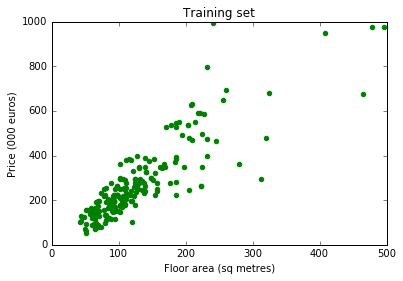

In [9]:
# Plot the data
fig = plt.figure()
plt.title("Training set")
plt.scatter(flareas, prices, color = 'green')
plt.xlabel("Floor area (sq metres)")
plt.xlim(0, 500)
plt.ylabel("Price (000 euros)")
plt.ylim(0, 1000)
plt.show()

<ul>
    <li>The goal of our learning algorithm is to fit a linear model to this data:
        $$\hat{y} = \beta_0 + \beta_1 \times \mathit{flarea}$$
    </li>
    <li>In other words, our goal is to choose values for $\beta_0$ and $\beta_1$
        <ul>
            <li>From the point of view of plotting this line, what's $\beta_0$? What's $\beta_1$?</li>
            <li>E.g. we could choose $\beta_0 = 800$ and $\beta_1 = -5$</li>
            <li>Or we could choose $\beta_0 = 200$ and $\beta_1 = 5$</li>
        </ul>
        Lets' refer to any particular choice as $h_{\v{\beta}}$ ($h$ for <b>hypothesis</b>)
            <ul>
                <li>The first example above is $h_{\rv{800, -5}}$</li>
                <li>The second example above is $h_{\rv{200, 5}}$</li>
            </ul>
    </li>
    <li>But there is an infinite set of linear models the algorithm can choose from
        <ul>
            <li>An infinite number of straight lines it can draw</li>
            <li>Or, equivalently, an infinite set of values from which it can pick $\beta_0$ and $\beta_1$</li>
        </ul>
    </li>
    <li>We want it to choose the one that best fits the data</li>
</ul>

<h2>Loss functions</h2>
<ul>
    <li>The algorithm needs a function that measures how well a model (hypothesis) fits the data
        <ul>
            <li>This is called its <b>loss function</b>, designated $J$</li>
            <li>The function takes in a particular $h_{\v{\beta}}$ and gives it a score
                <ul>
                    <li>Low numbers are better!</li>
                </ul>
            </li>
            <li>For each $\v{x}$ in the training set, it will compare $h_{\v{\beta}}(\v{x})$, which is the
                <em>prediction</em> that $h_{\v{\beta}}$ makes on $\v{x}$, with the <em>actual</em>
                value $y$
            </li>
        </ul>
    </li>
    <li>The loss function most usually used for linear regression is the <b>mean squared error</b>:
        <ul>
            <li>The difference between the prediction and the actual value, squared</li>
            <li>But averaged over all the examples in the training set</li>
        </ul>
        $$J(\v{X}, \v{y}, h_{\v{\beta}}) = \frac{1}{m}\sum_{i=1}^m(h_{\v{\beta}}(\v{x}^{i)}) - \v{y}^{(i)})^2$$
        <ul>
            <li>Why do you think we square the differences? (Two reasons)</li>
        </ul>
    </li>
    <li>The best model is the one that <em>minimizes</em> the loss function</li>
    <li>Hence, this is often referred to as <b>ordinary least-squares regression</b> (OLS)</li>
    <li>In fact, we often divide by 2:
        $$J(\v{X}, \v{y}, h_{\v{\beta}}) = \frac{1}{2m}\sum_{i=1}^m(h_{\v{\beta}}(\v{x}^{i)}) - \v{y}^{(i)})^2$$
        &mdash; the 'winner' is still the same, but this makes the calculus 'tidier' later
    </li>
</ul>

<h2>The loss function in numpy</h2>
<ul>
    <li>Looks like a loop: work out $h_{\v{\beta}}$ for each $\v{x}^{(i)}$
        <ul>
            <li>But $h_{\v{\beta}}$ is a linear equation, and we want to evaluate it lots of times (for
                each example $\v{x}^{(i)}$)
            </li>
            <li>So we use the vectorized approach from above (assuming all the examples contain an
                extra element, $\v{x}_0^{(i)} = 1$)
            </li>
        </ul>
    </li>
    <li>So our code can simply do this:
        $$J(\v{X}, \v{y}, \v{\beta}) = \frac{1}{2m}(\v{X}\v{\beta} - \v{y})^2$$
    </li>
</ul>

In [10]:
# Loss function for OLS regression (assumes X contains all 1s in its first column)
def J(X, y, beta):
    return np.mean((X.dot(beta) - y) ** 2) / 2.0

<h2>Now let's find a model</h2>

In [11]:
# Use pandas to read the CSV file
df = pd.read_csv("datasets/dataset_corkA.csv")

# Get the feature-values (just flarea) and the target values 
X = df[["flarea"]].values
y = df["price"].values

# Add the extra column to X
X_augmented = add_dummy_feature(X)

In [12]:
# I invite yout to modify these values 
beta = np.array([800, -5])

# Calculate the loss
loss = J(X_augmented, y, beta)

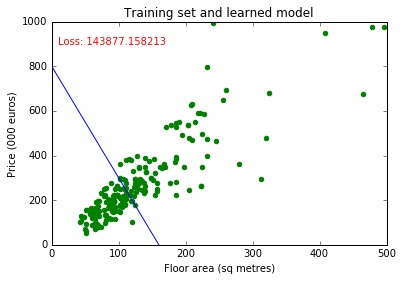

In [13]:
# Then plot the training data and the model
fig = plt.figure()
plt.title("Training set and learned model")
plt.scatter(X, y, color = "green")
xvals = np.array([[1, 0], [1, 500]])
plt.plot(xvals, xvals.dot(beta), color = "blue")
plt.text(10, 900, "Loss: " + str(loss), color = "red")
plt.xlabel("Floor area (sq metres)")
plt.xlim(0, 500)
plt.ylabel("Price (000 euros)")
plt.ylim(0, 1000)
plt.show()

<ul>
    <li>Keep modifying $\v{\beta}$ until you find the lowest loss</li>
</ul>

<h1>Linear Regression: Multivariate</h1>
<ul>
    <li>We considered only one feature ($\mathit{flarea}$)
        <ul>
            <li>This enabled easy visualisation on a 2D plot</li>
            <li>The model is a straight line</li>
        </ul>
    </li>
    <li>The only differences when we move to more than one feature (stats-speak: multivariate):
        <ul>
            <li>We can't plot so easily</li>
            <li>The model is a plane (when there are two features)</li>
            <li>The model is a hyperplane (when there are more than two features)</li>
        </ul>
    </li>
    <li><em>All the maths and the Python for the loss function remain the same</em></li>
</ul>

<h2>Now let's find a model using two features</h2>

In [14]:
# Use pandas to read the CSV file
df = pd.read_csv("datasets/dataset_corkA.csv")

# Get the feature-values (just bdrms and bthrms) and the target values 
X = df[["bdrms", "bthrms"]].values
y = df["price"].values

# Add the extra column to X
X_augmented = add_dummy_feature(X)

In [15]:
# I invite you to modify these values 
beta = np.array([100, 50, 50])

# Calculate the loss
loss = J(X_augmented, y, beta)

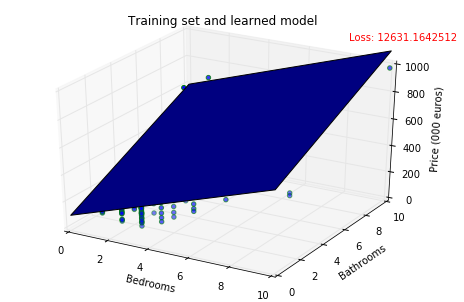

In [16]:
# Then plot the training data and the model
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title("Training set and learned model")
ax.scatter(X[:,0], X[:,1], y, color = "green")
xvals = np.linspace(0, 10, 2)
yvals = np.linspace(0, 10, 2)
xxvals, yyvals = np.meshgrid(xvals, yvals)
ax.plot_surface(xxvals, yyvals, beta[0] + beta[1] * xxvals + beta[2] * yyvals)  
ax.text(6, 14, 900, "Loss: " + str(loss), color = "red")
ax.set_xlabel("Bedrooms")
ax.set_xlim(0,10)
ax.set_ylabel("Bathrooms")
ax.set_ylim(0, 10)
ax.set_zlabel("Price (000 euros)")
ax.set_zlim(0, 1000)
plt.show()

<ul>
    <li>Keep modifying $\v{\beta}$ until you find the lowest loss</li>
</ul>

<ul>
    <li>We can't do a similar example with 3 or more features
        <ul>
            <li>Because we can't plot them</li>
        </ul>
    </li>
</ul>

<h1>Finding OLS Models</h1>
<ul>
    <li>We've been trying out different values for $\v{\beta}$, looking for the model with
        lowest mean squared error
        <ul>
            <li>by trial and error!</li>
        </ul>
        In practice, it is not done by trial-and-error
    </li>
    <li>There are two main methods:
        <ul>
            <li>The normal equation (<code>LinearRegression</code> class in scikit-learn)</li>
            <li>Various forms of gradient descent (<code>SGDRegressor</code> class in scikit-learn)</li>
        </ul>
    </li>
    <li>We give a quick example of the first of these
        <ul>
            <li>(No need to add the extra column: the <code>LinearRegression</code> class does it for us)</li>
        </ul>
    </li>
</ul>

In [17]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("datasets/dataset_corkA.csv")

In [18]:
# The features we want to select
numeric_features = ["flarea", "bdrms", "bthrms", "floors"]
nominal_features = ["type", "devment", "ber", "location"]

# Create the pipelines
numeric_pipeline = Pipeline([
        ("selector", DataFrameSelector(numeric_features))
    ])

nominal_pipeline = Pipeline([
        ("selector", DataFrameSelector(nominal_features)), 
        ("binarizer", FeatureBinarizer([df[feature].unique() for feature in nominal_features]))])

pipeline = Pipeline([("union", FeatureUnion([("numeric_pipeline", numeric_pipeline), 
                                             ("nominal_pipeline", nominal_pipeline)]))])

In [19]:
# Create the estimator
linreg = LinearRegression()

In [20]:
# Get the labels
y = df["price"].values

In [21]:
# Run the pipeline to prepare the data
pipeline.fit(df)
X = pipeline.transform(df)

In [22]:
# Fit the linear model
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
# Create your house
your_house_df = pd.DataFrame([{"flarea":114.0, "type":"Semi-detached", "bdrms":3, "bthrms":2, "floors":2,  
                               "devment":"SecondHand", "ber":"B2", "location":"Glasheen"}])

# Transform it using the pipeline
your_house_scaled = pipeline.transform(your_house_df)

# Predict its selling price
linreg.predict(your_house_scaled)

array([ 270.2835876])

<ul>
    <li>(In the next lecture, we will see how to include the linar regression step in the pipeline)</li>
</ul>